In [1]:
import warnings;
warnings.filterwarnings('ignore');

<div style="page-break-after: always;"></div>

# บทที่ 5. โครงข่ายประสาทเทียมวกกลับ

ปัญหาการเรียนรู้เชิงลึกที่เราได้ศึกษาจนถึงบทนี้จะเห็นว่าข้อมูลแต่ละตัวอย่างไม่มีความสัมพันธ์กัน 
เช่นการจำแนกภาพสุนัขและแมวที่โมเดลรับอินพุตแต่ละภาพเป็นเอกเทศ 
ในบทนี้จะพิจารณากรณีข้อมูลมีลักษณะเป็นลำดับ (sequence) เช่นชุดของภาพแมวที่ถ่ายจากวีดีโอขณะกำลังวิ่ง 
และต้องการให้โมเดลเรียนรู้การเคลื่อนไหวของวัตถุในภาพ หากอินพุตเป็นภาพแมวเพียงภาพเดียว 
เราอาจไม่ทราบได้ว่าแมวจะเคลื่อนไหวอย่างไรต่อไป แต่ถ้าเป็นลำดับของภาพชุดหนึ่งของแมววิ่งจากซ้ายไปขวา 
โมเดลสามารถจำแนกได้ว่าเป็นกิจกรรมการวิ่ง หรือพยากรณ์ตำแหน่งต่อไปของแมวได้

ปัญหาที่เกี่ยวข้องกับข้อมูลลำดับเป็นโจทย์สำคัญด้านการเรียนรู้เชิงลึกที่ครอบคลุมการใช้งานหลายรูปแบบ 
เช่นการประมวลผลภาษาธรรมชาติ (natural language processing นิยมเรียกโดยย่อว่า NLP) การแปลภาษาโดยเครื่อง
การรู้จำเสียงพูด (speech recognition) การกำเนิดดนตรี การจำแนกอารมณ์ (sentiment classification) 
การวิเคราะห์ลำดับ DNA การรู้จำกิจกรรมจากลำดับภาพวีดีโอ เป็นต้น

โดยลักษณะของโจทย์ปัญหาที่แตกต่างนี้ทำให้สถาปัตยกรรมโครงข่ายประสาทเทียมแบบ DNN หรือ CNN มีข้อด้อยสองประการคือ 

<ol>
<li />ไม่สามารถเรียนรู้และใช้ประโยชน์จากความสัมพันธ์ของข้อมูลลำดับ
<li />อินพุตมีลักษณะที่มีขนาดไม่คงที่ เช่นจำนวนอักขระในแต่ละคำ
</ol>

ในบทนี้เราจะนำเสนอโมเดลที่เหมาะสมสำหรับงานในรูปแบบนี้

## 5.1 สัญกรณ์สำหรับข้อมูลลำดับ

ก่อนเริ่มต้นการศึกษาในบทนี้จะนิยามสัญกรณ์เพิ่มเติมสำหรับข้อมูลลำดับ โดยยกตัวอย่างคำภาษาอังกฤษที่ประกอบเป็นประโยค 
ซึ่งหลักการสามารถประยุกต์กับภาษาโดยทั่วไป กรณีที่เป็นภาษาไทยจะมีความซับซ้อนเพิ่มขึ้นจากการตัดคำในประโยค 
ซึ่งมิใช่ส่วนที่ต้องการเน้นในด้านการเรียนรู้เชิงลึก

สมมุติว่าต้องการสร้างโมเดลลำดับเพื่อรับประโยคอินพุตดังนี้

X : Yngwie Malmsteen and Steve Vai performed together in Boston.
    
และต้องการให้โมเดลจำแนกว่าคำใดบ้างที่เป็นชื่อของคน ดังนั้นต้องการเอาต์พุต y มีค่าเป็น 1 หากคำนั้นเป็นส่วนของชื่อคน 
(ชื่อหรือนามสกุล) หากไม่ใช่ให้มีค่าเป็น 0 ดังนั้นจากประโยคอินพุตนี้จะได้เอาต์พุตเท่ากับ

$$
Y =  [1, 1, 0, 1, 1, 0, 0, 0, 0] 
$$    

ต้องการแทนแต่ละคำในประโยคของอินพุตด้วยสัญกรณ์โดย $x^{<t>}$ ซึ่ง $t$ คือตัวชี้ตำแหน่งของคำในประโยค 
ดังนั้นอินพุตจากประโยคด้านบนแทนได้เป็นดังนี้

$$
X = [x^{<1>}, x^{<2>}, \ldots, x^{<t>}, \ldots, x^{<9>}]
$$

และเอาต์พุต

$$
Y = [y^{<1>}, y^{<2>}, \ldots, y^{<t>}, \ldots, y^{<9>}]
$$

ให้ $T_x, T_y$ แทนจำนวนสมาชิกของอินพุตและเอาต์พุตตามลำดับ จากตัวอย่างนี้มีจำนวนเท่ากันคือ $9$ 
แต่โดยทั่วไปแล้วไม่จำเป็นต้องเท่ากัน 

ทบทวนจากสัญกรณ์เดิมเราใช้ $x^{(i)}, y^{(i)}$ แทนอินพุตและเอาต์พุตตัวอย่างที่ $i$ ดังนั้น 
$x^{(i)<t>}, y^{(i)<t>}$ แทนอินพุตและเอาต์พุตสมาชิกลำดับ 
$t$ ของตัวอย่าง $i$ ซึ่งจำนวนสมาชิกของแต่ละอินพุต/เอาต์พุต $T_x^{(i)}, T_y^{(i)}$ 
ในแต่ละตัวอย่างไม่จำเป็นต้องเท่ากัน

ต่อมาเราพิจารณาแต่ละสมาชิกของอินพุตในตัวอย่างหนึ่งที่อยู่ในรูปคำภาษาอังกฤษ 
การที่จะจะประมวลผลโดยโมเดลได้จะต้องแปลงให้อยู่ในรูปที่สามารถดำเนินการทางคณิตศาสตร์ได้ 
วิธีการพื้นฐานคือสร้างลิสต์สำหรับเก็บคำศัพท์ หรือดิกชันนารีที่เรียงคำศัพท์ตามอักขระตั้งแต่ a-z 
เช่นตัวชี้แรกเป็นคำนำหน้านาม "a" ตัวสุดท้ายเป็นคำว่า "zulu" ดิกชันนารีนี้ครอบคลุมทุกคำศัพท์ที่ใช้เป็นอินพุตของโมเดล 
สำหรับคำที่ไม่มีอาจนิยามเป็น "\<unk\>" (unknown) 
ดังนั้นแต่ละคำในประโยคอินพุตของตัวอย่างหนึ่งจะถูกแทนด้วยตัวเลขที่เป็นตัวชี้ในดิกชันนารี เช่นจากประโยคด้านบนอาจแทนโดย

$$
X = [9240, 5321, 127, 7441, 8739, 6716, 7913, 4471, 942]
$$

ขนาดของดิกชันนารีขึ้นกับจำนวนคำศัพท์ที่ต้องการ โจทย์ขนาดเล็กอาจมีสมาชิกหลักหมื่น 
ขณะที่การใช้งานให้ครอบคลุมทุกคำที่มีใช้ในอินเทอร์เน็ตอาจมีขนาดเป็นหลักล้านหรือมากกว่า 
จากตัวอย่างที่นำเสนอด้านบนสมมุติว่าใช้ดิกชันนารีขนาด 10,000 คำศัพท์ 
วิธีการอย่างง่ายคือแทนคำศัพท์เหล่านี้ในรูปแบบที่เรียกกันว่า <em>วันฮ็อต (one-hot)</em> 
คือเป็นเวกเตอร์ที่มีสมาชิกเพียงตัวเดียวเท่ากับหนึ่งที่เหลือเป็นศูนย์หมด เช่นคำว่า "Yngwie" 
อยู่ตำแหน่งที่ 9240 ในดิกชันนารี (อาจต้องเพิ่มคำนี้เข้าไปเพราะมิใช่ชื่อที่ใช้กันโดยทั่วไป)
ดังนั้นแทนด้วยเวกเตอร์ความยาวเท่ากับขนาดของดิกชันนารี คือ 10,000 
มีสมาชิกทุกตัวเท่ากับ 0 ยกเว้นสมาชิกตำแหน่งที่ 9240 เท่านั้นที่มีค่าเท่ากับ 1 คำว่า "and" 
มีเพียงสมาชิกตำแหน่งที่ 127 เท่ากับ 1 เป็นต้น

## 5.2 โครงข่ายประสาทเทียมวกกลับ

จากข้อจำกัด 2 ประการของโมเดล DNN หรือ CNN ที่เราได้ศึกษาก่อนหน้านี้ทำให้ไม่สามารถใช้งานกับข้อมูลลำดับได้อย่างเหมาะสม 
ดังนั้นจึงมีการนำเสนอสถาปัตยกรรมอีกรูปแบบหนึ่งที่กลายเป็นต้นแบบสำหรับโมเดลที่ใช้กับข้อมูลลำดับเรียกว่า 
<em>โครงข่ายประสาทเทียมวกกลับ (recurrent neural network)</em> เรียกโดยย่อว่า RNN รูปที่ 5.1 แสดงแผนภาพของโมเดล RNN 
แบบที่มีการไหลของสถานะในทิศทางเดียว (unidirectional) โดยมีลักษณะการแสดง 2 รูปแบบที่สมนัยกัน 
ทางด้านซ้ายคือการคลี่โมเดลออก (unroll) ให้เห็นถึงโครงสร้างภายในอย่างชัดเจน ส่วนทางด้านขวาคือการเขียนให้กระชับขึ้น 
ในหนังสือนี้จะยึดแผนภาพทางด้านซ้ายเป็นหลัก พารามิเตอร์การเรียนรู้ในแผนภาพแสดงเพียงค่าน้ำหนัก $W$ 
โดยละค่าเอนเอียงไว้เพื่อลดความหนาแน่นของสัญกรณ์ในภาพลง แผนภาพของโมเดล RNN ในรูปที่ 5.1 ที่มีค่า $T_x = T_y$
เป็นเพียงหนึ่งในหลายรูปแบบที่จะกล่าวถึงต่อไป

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1y3xgInzVINn5AgjDc_MKLXnqGQ1FfTux" width=650 />
</p>
<div align="center">รูปที่ 5.1 แผนภาพโครงข่ายประสาทเทียมวกกลับ (RNN)</div>

เมือพิจารณาแผนภาพด้านซ้ายในรูปที่ 5.1 แท่งสี่เหลี่ยมในแนวตั้งแทน DNN ที่มีจำนวนชั้นตามที่กำหนด มีอินพุตคือ $x$ 
และเอาต์พุต $\hat{y}$ เหมือนที่ได้ศึกษาในบทที่ 2 แต่จะมีตัวชี้ของลำดับข้อมูลกำกับอยู่ 
สังเกตว่าโมเดลในแนวตั้งมีเพียงตัวเดียว แต่คลี่ออกให้เห็นการทำงานตามลำดับ
สิ่งที่แตกต่างสำหรับโมเดล RNN คือจะมีการส่งผ่านสถานะ $h$ จากลำดับก่อนหน้ายังลำดับต่อไป 
หากมองการทำงานของโมเดลเป็นขั้นของเวลาอาจทำให้เข้าใจได้ง่ายขึ้น เมื่อกำหนดสถานะเริ่มต้น $h^{<0>} = 0$ 
โมเดลรับอินพุตเป็นสมาชิกแรกของลำดับคือ $x^{<1>}$ ผ่านชั้นของ DNN ได้เอาต์พุต $\hat{y}^{<1>}$ 
ขณะเดียวกันคำนวณสถานะ $h^{<1>}$ เพื่อนำมาใช้ในขั้นเวลาต่อไป 
โดยการทำงานที่ซ้ำเดิมเช่นนี้จึงเป็นที่มาของชื่อ "โครงข่ายประสาทเทียมวกกลับ"

### 5.2.1 การแพร่กระจายข้างหน้าของ RNN

การแพร่กระจายข้างหน้าของ RNN ดังในรูปที่ 5.2 ในแต่ละขั้นเวลาสามารถบรรยายโดยสมการคณิตศาสตร์ดังนี้

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1DwB8cmb608zjWpjn6jvngwNnxrCy492p" width=650 />
</p>
<div align="center">รูปที่ 5.2 การแพร่กระจายข้างหน้าของ RNN</div>
<p />
$$
h^{<t>} = f(W_{hh}h^{<t-1>} + W_{hx}x^{<t>}+b_h) \tag{5.1}
$$

$$
\hat{y}^{<t>} = g(W_{yh}h^{<t>}+b_y) \tag{5.2}
$$

โดยกำหนดค่าเริ่มต้นของสถานะ $h^{<0>} = 0$ และใช้พารามิเตอร์น้ำหนักและค่าเอนเอียงชุดเดียวตลอดทั้งแผนภาพ
ฟังก์ชันกระตุ้น $f()$ สำหรับสถานะ นิยมใช้ฟังก์ชัน <code>tanh()</code> หรืออาจพบเห็นการใช้ <code>ReLU()</code> 
ในบางกรณี ส่วนฟังก์ชันกระตุ้น $g()$ สำหรับพยากรณ์เอาต์พุตจะเหมือนกับที่ใช้ใน DNN ปกติ คือ <code>sigmoid()</code> 
ในการจำแนกทวิภาคและ <code>softmax()</code> ในการจำแนกหลายประเภท 

เราสามารถทำสมการ (5.1) ให้กระชับขึ้นโดยนิยาม

$$
W_h = \begin{bmatrix}
W_{hh} & W_{hx} 
\end{bmatrix} \;\;\text{(5.3)}
$$

$$
[h^{<t-1>}, x^{<t>}] = \begin{bmatrix}
h^{<t-1>} \\
x^{<t>}
\end{bmatrix} \;\;\text{(5.4)}
$$

ดังนั้น (5.1) สามารถเขียนใหม่ได้เป็น

$$
h^{<t>} = f(W_{h}[h^{<t-1>}, x^{<t>}] + b_h) \tag{5.5}
$$

### 5.2.2 การแพร่กระจายย้อนหลังของ RNN


แผนภาพการแพร่กระจายย้อนหลังแสดงได้ดังรูปที่ 5.3 จากเอาต์พุต $\hat{y}^{<t>}$ ที่พยากรณ์ได้จากการแพร่กระจายข้างหน้า สามารถคำนวณค่าสูญเสีย 
$\mathcal{L}^{<t>}$ โดยเปรียบเทียบกับเอาต์พุตค่าจริง $y^{<t>}$ ตัวอย่างเช่นปัญหาการจำแนกทวิภาคสามารถนิยามฟังก์ชันสูญเสียในแต่ละขั้นเวลาแบบการถดถอยลอจิสติก
หรือที่เรียกว่า ครอสเอนโทรปี

$$
\mathcal{L}^{<t>}(\hat{y}^{<t>},y^{<t>}) = -y^{<t>}log(\hat{y}^{<t>}) - (1-y^{<t>})log (1-\hat{y}^{<t>}) \tag{5.6} 
$$

ค่าสูญเสียรวมนิยามได้เป็นผลรวมของค่าสูญเสียในแต่ละขั้นของเวลา

$$
\mathcal{L}(\hat{y},y) = \sum_{t=1}^{T_y}\mathcal{L}^{<t>}(\hat{y}^{<t>},y^{<t>}) \tag{5.7} 
$$

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1KBmLL9GEujp47-jbjbORajeColfYiTQ8" width=650 />
</p>
<div align="center">รูปที่ 5.3 การแพร่กระจายย้อนหลังของ RNN</div>

จากค่าสูญเสียนี้ทำให้เราสามารถคำนวณอนุพันธ์เทียบกับค่าพารามิเตอร์เพื่อใช้ในการปรับค่าให้เข้าสู่ค่าสูญเสียต่ำสุดเหมือนดังที่ได้เคยศึกษาแล้ว 
อย่างไรก็ตามในการกระจายย้อนหลังของโมเดล RNN มีส่วนที่น่าสนใจคือการไหลในทิศทางแนวนอนจากขวามาซ้ายในรูปที่ 5.3 
มีชื่อเรียกว่า <em>"การกระจายย้อนหลังผ่านเวลา" (back propagatin through time)</em>
ซึ่งให้ความรู้สึกเหมือนการเดินทางผ่านเวลาในภาพยนต์นิยายวิทยาศาสตร์ 

### 5.2.3 สถาปัตยกรรมของ RNN จำแนกตามจำนวนอินพุตและเอาต์พุต

จากโมเดล RNN ที่ยกตัวอย่างในรูปที่ 5.1 เป็นกรณีที่จำนวนลำดับของอินพุตกับเอาต์พุตเท่ากัน ซึ่งเป็นประเภทหนึ่งในหลายประเภทของสถาปัตยกรรม RNN 
ที่แสดงในรูปที่ 5.4 คืออยู่ในประเภท (d) 


<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1WstYfkuTTMoA4GyfbECmPwSfDP_rUrHh" width=650 />
</p>
<div align="center">รูปที่ 5.4 สถาปัตยกรรมของ RNN</div>

สถาปัตยกรรมในรูปที่ 5.4 จะละเว้นกรณีที่โมเดลมีเพียงหนึ่งอินพุตหนึ่งเอาต์พุต ซึ่งจะกลายเป็นโมเดล DNN ธรรมดา 
สำหรับประเภท (a) - (d)  อธิบายได้ดังนี้

(a) <u>โมเดลหลายอินพุตหนึ่งเอาต์พุต</u> ใช้ในปัญหาการจำแนกประเภทของอินพุตที่อาจเป็นประโยคข้อความ เสียง หรือข้อมูลอันดับอื่น 
โมเดลจะให้ค่าของเอาต์พุตเป็นประเภทของการจำแนก หรือการตัดสินแบบทวิภาค 
ตัวอย่างเช่นการตัดสินอารมณ์ของของลูกค้าว่าพอใจหรือไม่พอใจในสินค้า/บริการ หรือการตรวจสอบเสียงพูดของผู้ใช้งานว่าตรงกับคำสั่งที่กำหนดไว้หรือไม่ 

(b) <u>โมเดลหนึ่งอินพุตหลายเอาต์พุต</u> ในกรณีนี้รวมถึงกรณีที่ไม่มีอินพุตเลย ตัวอย่างเช่นการกำเนิดดนตรี เราอาจป้อนอินพุตเป็นตัวเลขที่แทนประเภทของดนตรี 
หรือกำหนดโน้ตตัวแรกของเพลง หรือไม่กำหนดค่าใดเลย คือ $x = \emptyset$
ในโมเดลนี้มักมีการป้อนเอาต์พุตของขั้นเวลาก่อนหน้าเป็นอินพุตของขั้นเวลาต่อมา

(c) <u>โมเดลหลายอินพุตหลายเอาต์พุต</u> ที่จำนวนอินพุต $T_x$ และจำนวนเอาต์พุต $T_y$ อาจแตกต่างกัน ตัวอย่างเช่นการแปลภาษาโดยเครื่อง 
สมมุติว่าต้องการสร้างโมเดลแปลจากภาษาอังกฤษเป็นเยอรมัน เราอาจเริ่มต้นโดยการอ่านประโยคอินพุตภาษาอังกฤษเข้ามาจนหมดก่อน 
เรียกว่า <em>ส่วนเข้ารหัส (encoder)</em> หลังจากนั้น <em>ส่วนถอดรหัส (decoder)</em> จึงทำหน้าที่ส่งเอาต์พุตภาษาเยอรมันออกไป

(d) <u>โมเดลหลายอินพุตหลายเอาต์พุต</u> มีจำนวนอินพุตและเอาต์พุตเท่ากัน $T_x = T_y$

</ul>

## 5.3 โมเดลลำดับขั้นสูงที่พัฒนาจาก RNN

ในบทที่ 3 เราได้อธิบายเกี่ยวกับปัญหาการที่เกรเดียนต์มีค่าสูงมาก (exploding gradients) หรือน้อยมากจนเรียกว่าการหายไปของเกรเดียนต์ 
(vanishing gradinets) 
ซึ่งเป็นปัญหาของโมเดลที่มีจำนวนชั้นแฝงมาก ปํญหานี้จะยิ่งทวีความรุนแรงสำหรับโมเดล RNN เนื่องจากมีลำดับขั้นเวลาเข้ามาเกี่ยวข้อง 
เสมือนกับว่าเพิ่มความลึกของโมเดลมากขึ้นอีก ระหว่างขอบเขตสองทิศทางของเกรเดียนต์นี้ 
ปัญหาเกรเดียนต์ค่าสูงจะแก้ไขได้ง่ายกว่าเพราะหากตรวจพบเราสามารถใช้ <em>วิธีการจำกัดค่าเกรเดียนต์ (gradient clipping)</em> 
แต่ในกรณีการหายไปของเกรเดียนต์เป็นเหตุผลหลักที่ทำให้โมเดล RNN ไม่สามารถเรียนรู้ลำดับที่มีความยาวและมีข้อมูลสำคัญอยู่ห่างกัน 

จะลองยกตัวอย่างภาษาไทยดูบ้าง สมมุติว่าเราต้องการสร้างโมเดลในการเรียนรู้ความคิดเห็นของลูกค้าที่โพสต์ในเพจของร้านอาหารร้านหนึ่ง 
และตัดสินว่าเป็นการชมหรือตำหนิเมนูอาหารของร้าน (โมเดล (a) ในรูปที่ 5.4) อินพุตเป็นข้อความดังนี้

"วันนี้ลองสั่ง<u>บะหมี่หมูกรอบ</u> ก่อนอื่นต้องขอกล่าวในฐานะที่ตัวเองเป็นคนดีและนักชิมอาหารตัวยงที่เดินทางไปทั่วประเทศไทยอันเป็นที่รักยิ่ง 
ถึงแม้ว่าได้วางแผนใช้ชีวิตหลังเกษียณในต่างประเทศ แต่เห็นว่าในโลกนี้ไม่มีที่ใหนดีเท่าประเทศไทยอีกแล้ว มาพบร้านนี้โดยบังเอิญ
และไม่ได้รู้จักกับเจ้าของร้านเป็นการส่วนตัว ต้องขอบอกว่า<u>รสชาติไม่ถูกปาก</u>"

สังเกตว่าในส่วนต้นของข้อความนี้ "บะหมี่หมูกรอบ" มีความสำคัญเพราะกล่าวถึงอาหารรายการหนึ่งที่ร้านอาหารนี้จำหน่าย 
แต่หลังจากนั้่นโมเดลจะรับอินพุตเป็นข้อความที่ยาวมากและไม่มีความสำคัญต่อการตัดสินใจ จนกระทั่งใกล้จบจึงพบคำว่า "รสชาติไม่ถูกปาก" 
ซึ่งประมวลได้เป็นผลด้านลบต่ออาหารรายการนี้ของร้าน อินพุตในลักษณะนี้สามารถทำให้เกิดปัญหาการหายไปของเกรเดียนต์ 
โมเดลต้องจำคำว่า "บะหมี่หมูกรอบ" นานหลายขั้นเวลามากก่อนจะถึงคำที่มีความสำคัญอีกคำหนึ่ง 
กล่าวได้ว่าขาดสมรรถนะด้านความจำในระยะยาว 
วิธีแก้ไขคือเพิ่มกลไกที่ช่วยให้โมเดลสามารถเรียนรู้และจดจำอินพุตที่มีความสำคัญได้จนถึงเวลาที่ต้องการใช้ 
ซึ่งโมเดลที่มีการนำเสนอใช้กลไกในรูปแบบของเกต (gate) และพารามิเตอร์การเรียนรู้ให้เปิด/ปิดข้อมูลในส่วนที่ต้องการ 

ปัจจุบันโมเดลที่ต่อยอดจาก RNN และใช้กันแพร่หลายคือ <em>GRU (gated recurrent unit)</em> และ 
<em>LSTM (long short term memory)</em> 
ซึ่งต่อไปจะแทนโดยชื่อย่อ ถึงแม้ว่า LSTM จะถูกนำเสนอก่อน แต่เนื่องจาก GRU มีความซับซ้อนน้อยกว่าดังนั้นจะกล่าวถึงเป็นลำดับแรก

### 5.3.1 โมเดล GRU 

หลักการของโมเดล GRU {cite}`cho2014properties`,{cite}`chung2014empirical` คือใช้เกต 2 ตัวเป็นกลไกเพื่อกำหนดว่าเมื่อไรต้องการจำหรือลืมข้อมูลสำคัญ และเลือกที่จะถ่ายทอดสถานะสำคัญนั้นผ่านขั้นเวลา 
หรือผ่านสถานะปกติ นิยาม <em>เกตสำหรับอัพเดต (update gate)</em>

$$
\Gamma_u^{<t>} = \sigma(W_u[h^{<t-1>}, x^{<t>}]+b_u) \tag{5.8}
$$

และ <em>เกตสำหรับรีเซต (reset gate)</em>

$$
\Gamma_r^{<t>} = \sigma(W_r[h^{<t-1>}, x^{<t>}]+b_r) \tag{5.9}
$$

โดย GRU มีพารามิเตอร์การเรียนรู้เพิ่มขึ้นคือ $W_u, b_u, W_r, b_r$ ข้อสังเกตจากกราฟของฟังก์ชันซิกมอยด์คือมีค่าเข้าสู่ระดับ 0 หรือ 1 เมื่ออินพุตมีค่ามากขึ้นด้านลบหรือบวก ดังนั้นเกตทั้งสองนี้จะทำงานในลักษณะปิด/เปิดเป็นส่วนใหญ่ 
คือเมื่อเกตมีค่าศูนย์ก็จะปิดกั้นไม่ให้อินพุตผ่าน ส่วนกรณีมีค่าเป็นหนึ่งก็จะให้อินพุตผ่านได้ นิยามสถานะที่เป็นทางเลือกคือ

$$
\tilde{h}^{<t>} = \tanh(W_{h}[\Gamma_r^{<t>}*h^{<t-1>}, x^{<t>}] + b_h) \tag{5.10}
$$

โดยเราจะใช้เครื่องหมาย \* แทนการคูณสมาชิกต่อสมาชิก สุดท้ายคือนิยามค่าสถานะที่จะส่งผ่านไปยังขั้นเวลาต่อไป

$$
h^{<t>} = \Gamma_u^{<t>}*\tilde{h}^{<t>} + (1-\Gamma_u^{<t>})*h^{<t-1>} \tag{5.11}
$$

จะเห็นว่าเมื่อ $\Gamma_u^{<t>} \approx 1$ คือต้องการอัพเดต (พบข้อมูลสำคัญและต้องการส่งผ่านความจำระยะยาว) 
สถานะที่ส่งผ่านคือ $\tilde{h}^{<t>}$ เนื่องจาก $(1-\Gamma_u^{<t>}) \approx 0$ 
ทำให้สถานะก่อนหน้า $h^{<t-1>}$ ถูกปิดกั้น ขณะเดียวกันในสมการ (5.10) ค่าของ $\Gamma_r^{<t>}$ 
เป็นตัวกำหนดว่าสถานะก่อนหน้ามีความสำคัญมากน้อยเพียงใด 
ส่วนอีกกรณีหนึ่งคือเมื่อ $\Gamma_u^{<t>} \approx 0$ สถานะที่ส่งผ่านคือสถานะก่อนหน้านี้เช่นเดียวกับโมเดล RNN ปกติ แผนภาพในรูปที่ 5.5 
แสดงการทำงานของกลไกใน GRU (ละเว้นส่วนเอาต์พุตเพื่อเน้นเฉพาะการส่งผ่านสถานะ)

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1GCIC815fihF6JhuDPpaT9wn5MtYAXKG5" width=550 />
</p>
<div align="center">รูปที่ 5.5 กลไกการส่งผ่านสถานะในโมเดล GRU</div>

### 5.3.2 โมเดล LSTM

LSTM {cite}`hochreiter1997long`เป็นโมเดลอีกรูปแบบหนึ่งที่ต่อยอดจาก RNN โดยเพิ่มกลไกในการบริหารความจำระยะยาว 
ถูกนำเสนอก่อนหน้า GRU มีความซับซ้อนมากกว่าเพราะประกอบด้วยเกต 3 ตัวทำหน้าที่สำหรับลืม อัพเดต 
และส่งค่าออกเอาต์พุตสถานะ โครงสร้างของ LSTM แสดงได้ดังในรูปที่ 5.6 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1m-7VVo9Hb2jsT-5CorN3uznK8F5eyOFv" width=550 />
</p>
<div align="center">รูปที่ 5.6 โครงสร้างภายในของโมเดล LSTM</div>

หลักการของโมเดล LSTM คือเพิ่มเส้นทางสำหรับความจำระยะยาวแยกต่างหากจากสถานะเดิมของ RNN 
มักเรียกสถานะนี้ว่า "เซลล์ความจำ" หรือสั้นลงเพียง "เซลล์" แทนด้วย $c^{<t>}$ 
ตัวเลือกในการส่งผ่านคือค่าเซลล์ความจำก่อนหน้า $c^{<t-1>}$ หรือค่าใหม่ที่คำนวณดังนี้

$$
\tilde{c}^{<t>} = \tanh(W_{c}[h^{<t-1>}, x^{<t>}] + b_c) \tag{5.12}
$$

เกตที่ทำหน้าที่อัพเดตข้อมูลสู่เซลล์ความจำจะมีรูปแบบเหมือนกับ GRU 

$$
\Gamma_u^{<t>} = \sigma(W_u[h^{<t-1>}, x^{<t>}]+b_u) \tag{5.13}
$$

แต่สำหรับ LSTM จะใช้เกตอีกตัวหนึ่งคือ $\Gamma_f^{<t>}$ เพื่อทำให้หยุดจำ (คือสั่งให้ลืมนั่นเอง)

$$
\Gamma_f^{<t>} = \sigma(W_f[h^{<t-1>}, x^{<t>}]+b_f) \tag{5.14}
$$

สุดท้ายคือเกตเอาต์พุต $\Gamma_o^{<t>}$

$$
\Gamma_o^{<t>} = \sigma(W_o[h^{<t-1>}, x^{<t>}]+b_o) \tag{5.15}
$$

ค่าที่อัพเดตไปยังเซลล์ความจำคำนวณได้ดังนี้

$$
c^{<t>} = \Gamma_u^{<t>}*\tilde{c}^{<t>} + \Gamma_f^{<t>})*c^{<t-1>} \tag{5.16}
$$

โดย \* แทนการคูณสมาชิกต่อสมาชิก ดังนั้นเซลล์ความจำของขั้นเวลาปัจจุบัน $c^{<t>}$ 
คือการเลือกระหว่างค่าเซลล์ความจำในขั้นเวลาก่อนหน้า $c^{<t-1>}$ หรือว่าค่าอัพเดต 
$\tilde{c}^{<t>}$ จาก (5.12) ขึ้นกับค่าของเกต $\Gamma_u^{<t>}$ และ $\Gamma_f^{<t>}$

สำหรับการส่งค่าสถานะ $h^{<t>}$ ถูกควบคุมโดยเกตเอาต์พุต $\Gamma_o^{<t>}$

$$
h^{<t>} = \Gamma_o^{<t>}*\tanh(c^{<t>}) \tag{5.17}
$$

การทำงานของ LSTM จะเป็นดังแผนภาพรูปที่ 5.7 โดยเส้นทางของเซลล์ความจำระยะยาว $c^{<t>}$ จะอยู่ด้านบน 
แยกจากสถานะ $h^{<t>}$ ซึ่งเมื่อพิจารณาว่าอินพุตมีความสำคัญ เช่นคำว่า "บะหมี่หมูกรอบ" ในตัวอย่างด้านบน 
$c^{<t>}$ จะถูกอัพเดต หลังจากนั้นถูกส่งผ่านขั้นเวลาหลายขั้นตามต้องการจนกว่าจะถูกสั่งให้ลืมคำนั้น 
ซึ่งการทำงานของเกตจะเรียนรู้ผ่านการฝึกโมเดล

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1B78MNr3yEySqREWiQkJlsQ9RUto99H5E" width=850 />
</p>
<div align="center">รูปที่ 5.7 แผนภาพคลี่ของ LSTM</div>

บางครั้งจะพบเห็นการใส่ค่าของเซลล์ความจำเข้าที่อินพุตของเกต เช่น

$$
\Gamma_o^{<t>} = \sigma(W_o[h^{<t-1>}, x^{<t>},c^{<t-1>}]+b_o) \tag{5.18}
$$

รวมถึงเกต $\Gamma_u^{<t>}, \; \Gamma_f^{<t>}$ วิธีการนี้มีชื่อเรียกว่า <em>การเชื่อมต่อช่องมอง 
(peephole connection)</em>

### 5.3.3 โมเดล RNN สองทิศทาง

โมเดลลำดับทั้งหมดที่กล่าวมาข้างต้นมีข้อจำกัดคือการส่งสถานะจะเป็นแบบทิศทางเดียว 
จึงไม่สามารถเรียนรู้ในกรณีข้อมูลลำดับมีส่วนสำคัญอยู่ในขั้นที่อยู่หลังอินพุตปัจจุบัน ยกตัวอย่างสองประโยคนี้

* คนทั่วไปรู้จัก "วัตสัน" "ว่าเป็นนามสกุลของดาราหญิงที่มีชื่อเสียง
* คนทั่วไปรู้จัก "วัตสัน" ว่าเป็นร้านขายอุปกรณ์เสริมสุขภาพและความงาม

หากโมเดลต้องการพยากรณ์คำว่า "วัตสัน" เป็นส่วนของชื่อคนหรือไม่ จะต้องรอการประมวลผลในส่วนหลังของประโยค 
ซึ่งเกิดขึ้นในขั้นเวลาภายหลัง และส่งสถานะย้อนกลับมา สถาปัตยกรรมที่เหมาะสมในกรณีนี้คือโมเดล 
RNN <em>สองทิศทาง (bidirectional)</em> ดังแสดงในรูปที่ 5.8
โดย $h_f^{<t>}$ และ $h_b^{<t>}$ คือสถานะที่ถ่ายทอดในทิศทางข้างหน้าและย้อนหลังตามลำดับ

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1pYGmdchKqZfNATC1e_QfdvRHCoPw9wC-" width=550 />
</p>
<div align="center">รูปที่ 5.8 โมเดล RNN สองทิศทาง</div>

การพยากรณ์เอาต์พุตเขียนได้เป็นสมการดังนี้

$$
\hat{y}^{<t>} = g(W_y[h_f^{<t>},h_b^{<t>}]+b_y) \tag{5.19}
$$

ยกตัวอย่างการพยากรณ์เอาต์พุต $\hat{y}^{<3>}$ เป็นฟังก์ชันของทั้งข้อมูล $x^{<1>},\; x^{<2>},$ $x^{<3>}$ 
โดยการส่งผ่านสถานะในทิศทางข้างหน้ามายัง $h_f^{<3>}$ 
และข้อมูลจาก $x^{<4>}$ ส่งย้อนหลังมายัง $h_b^{<3>}$ การส่งสถานะสองทิศทางนี้สามารถขยายไปยังโมเดลลำดับขั้นสูงคือ 
GRU และ LSTM ได้เช่นเดียวกัน 

### 5.3.4 โมเดล RNN เชิงลึก

จากเนื้อหาประกอบรูปที่ 5.1 เราได้อธิบายว่าแท่งสี่เหลี่ยมในแนวตั้งแทน DNN ที่มีจำนวนชั้นตามที่กำหนด ดังนั้นโดยตัวเองจึงเป็นโมเดลเชิงลึกอยู่แล้วในระดับหนึ่ง 
แต่สังเกตจากสถานะที่ส่งผ่านที่ใช้สัญกรณ์ $h^{<t>}$ จะเป็นเวกเตอร์ที่เป็นเอาต์พุตจากฟังก์ชันไม่เป็นเชิงเส้น (5.1) โดยมีอินพุตคือ $x^{<t>}$ และ 
$h^{<t-1>}$ 

โมเดล RNN เชิงลึกในหัวข้อย่อยนี้เป็นการขยายจากโมเดล RNN พื้นฐานในรูปที่ 5.1 เป็นโครงสร้างที่ซับซ้อนขึ้นดังแสดงในรูปที่ 5.9 จะใช้สัญกรณ์
$a^{[l]<t>}$ แทนฟังก์ชันกระตุ้นที่เอาต์พุตของชั้น $l$ ณ ขั้นลำดับ $t$ ซึ่งสามารถถ่ายโอนเอาต์พุตของแต่ละชั้นไปยังขั้นลำดับต่อไป 
คำนวณได้ตามสมการดังนี้

$$
a^{[l]<t>} = g(W_a^{[l]}[a^{[l]<t-1>}, a^{[l-1]<t>}]+b_a^{[2]}) \tag{5.20}
$$

โดย $g()$ คือฟังก์ชันกระตุ้นที่ต้องการใช้ 
ในทางอุดมคติเราอาจต้องการสร้างโมเดลเชิงลึก 100 ชั้นแฝงแล้วถ่ายโอนเอาต์พุต $a^{[l]<t>}$ ของแต่ละชั้นแฝงเป็นสถานะลำดับ 
แต่ในทางปฏิบัติจะมีความซับซ้อนในการประมวลผลมากเกินกว่าจะใช้งานได้ ดังนั้นอาจเลือกส่งเอาต์พุต $a^{[l]<t>}$ เพียงชั้นแฝงต้นจำนวนไม่มาก 
ส่วนชั้นแฝงที่เหลือทำงานเป็น DNN ปกติเหมือนในรูปที่ 5.9 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=15zxO6fw6TndhpQ84Th5wYnXfY0UbSwVM" width=750 />
</p>
<div align="center">รูปที่ 5.9 โมเดล RNN เชิงลึก</div>

แน่นอนว่าเราสามารถผสมผสานโมเดลที่กล่าวถึงทั้งหมดเข้าด้วยกัน เช่นโมเดล LSTM สองทิศทางแบบเชิงลึก 

## 5.4 สร้างโมเดลลำดับโดยไลบรารี TF

ในหัวข้อนี้เป็นการศึกษาวิธีการสร้างโมเดล RNN และ LSTM บนกรอบการทำงานของ TF 
โดยใช้ข้อมูลสังเคราะห์ที่อธิบายในภาคผนวก A 

**ตัวอย่าง 5.1**

จากภาคผนวก A เราได้ใช้โมเดล DNN พยากรณ์ข้อมูลอนุกรมเวลาสังเคราะห์ โดยได้สมรรถนะที่ดีในระดับหนึ่ง 
คือค่าผิดพลาด mse=298.72, mae = 13.63 (ค่าอาจแตกต่างกันไปบ้างในการรันแต่ละครั้ง) 
ในตัวอย่างนี้ต้องการสร้างโมเดลโดยใช้ RNN เพื่อพยากรณ์ข้อมูลเดิม 
เพื่อความสะดวกได้นำเอาโค้ดสำหรับสร้างอนุกรมเวลาสังเคราะห์มาใส่ในเซลล์ด้านล่างนี้ 
รวมถึงโค้ดสำหรับแบ่งข้อมูลฝึกและตรวจสอบ และจัดรูปข้อมูลฝึก
(อ่านคำอธิบายได้ในภาคผนวก A)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #suppress logging output for book publishing

In [5]:
def plot_series(time, series, format="-", start=0, end=None, label=None,xlabel="time (days)",ylabel="value"):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(t, slope=0):
    return slope * t

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    -np.cos(season_time * 2.8 * np.pi),
                    -0.1*np.exp(2.3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1):
    return np.random.randn(len(time)) * noise_level



In [6]:
baseline = 50
amplitude = 50
slope = 0.04
noise_level=15
sample_time = np.arange(4 * 365 + 1)
sample_series = baseline + trend(sample_time, slope) + seasonality(sample_time, period=365, amplitude=amplitude)+noise(sample_time, noise_level)
#plot_series(sample_time, sample_series)

In [7]:
split_time = 365*3
time_train = sample_time[:split_time]
x_train = sample_series[:split_time]
time_valid = sample_time[split_time:]
x_valid = sample_series[split_time:]

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [10]:
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

สร้างโมเดลลำดับโดยใช้ชั้น <code>SimpleRNN()</code> ซ้อนกัน 2 ชั้น โดยในชั้นแรกจะต้องใช้อาร์กิวเมนต์ 
<code>return_sequence = True</code> ให้ลำดับทั้งหมดออกที่เอาต์พุตของชั้นแรกเพื่อเป็นอินพุตของชั้นที่สอง 
สำหรับชั้นที่สองมีเอาต์พุตเดียว ใช้ชั้น <code>Dense(1)</code> รองรับ ส่วนชั้น <code>Lambda()</code> 
ชั้นบนสุดทำหน้าที่ปรับรูปของอินพุตจากฟังก์ชัน <code>windowed_dataset()</code> ให้สอดคล้องกับโมเดล 
ชั้น <code>Lambda()</code> สุดท้ายทำหน้าที่ปรับมาตราส่วนให้เหมาะสม โค้ดในการสร้างโมเดลเป็นดังนี้ 

In [11]:
rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

คอมไพล์โดยกำหนดอัตราการเรียนรู้ที่เหมาะสม (อาจต้องมีการทดลองปรับหลายครั้ง) และใช้ตัวหาค่าเหมาะที่สุดแบบ <code>Adam</code>
และตั้งค่าสูญเสียเป็นแบบ [Huber](https://en.wikipedia.org/wiki/Huber_loss) 
ที่มีความไวต่อการรบกวนน้อยกว่าแบบ <code>mse</code>

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)


In [13]:
rnn_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

ฝึกโมเดลโดยข้อมูลที่จัดรูปแล้วเป็นจำนวน 400 รอบ (หากต้องการแสดงผลเอาต์พุตในระหว่างฝึก ตั้งค่า <code>verbose</code> ไม่เป็นศูนย์)

In [14]:
rnn_history = rnn_model.fit(train_dataset,epochs=400,verbose=0)

ดูผลการพยากรณ์จากโมเดลได้ดังรูปที่ 5.10

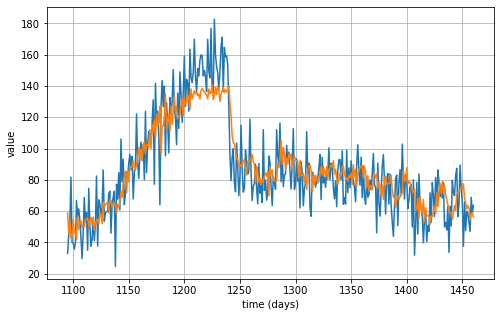

In [15]:
rnn_forecast=[]
for time in range(len(sample_series) - window_size):
    rnn_forecast.append(rnn_model.predict(sample_series[time:time + window_size][np.newaxis],verbose=0))

rnn_forecast = rnn_forecast[split_time-window_size:]
rnn_results = np.array(rnn_forecast)[:, 0, 0]


plt.figure(figsize=(8, 5))

plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_results)

<div align="center">รูปที่ 5.10 ผลการพยากรณ์จากโมเดล RNN</div>

จากผลการพยากรณ์จะเห็นว่ามีค่าผิดพลาดมากในบริเวณส่วนยอดของข้อมูล
ตรวจสอบค่าตัววัดเปรียบเทียบกับผลจากภาคผนวก A พบว่ามีค่าสูงกว่าเล็กน้อย 

In [16]:
print(keras.metrics.mean_squared_error(x_valid, rnn_results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, rnn_results).numpy())

285.60217
13.305743


<div style=".noindent"><b>ตัวอย่าง 5.2</b></div>

ในตัวอย่างนี้จะใช้ข้อมูลเดิมจากตัวอย่าง 5.1 แต่เปลี่ยนชั้น RNN ในโมเดลเป็นชั้น LSTM สองทิศทาง โค้ดสำหรับสร้างโมเดลเป็นดังนี้

In [17]:
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


คอมไพล์โดยใช้อาร์กิวเมนต์เหมือนในตัวอย่าง 5.1 และฝึกจำนวนเท่ากัน

In [18]:
lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mae"])

In [19]:
lstm_history = lstm_model.fit(train_dataset,epochs=400,verbose=0)

ดูผลการพยากรณ์จากโมเดลได้ดังรูปที่ 5.11

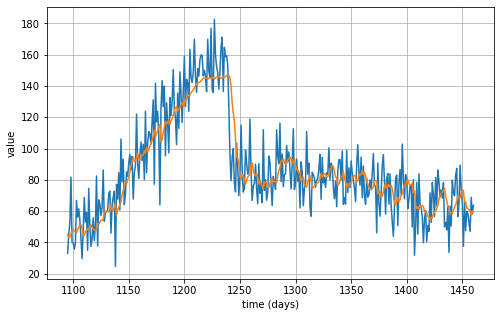

In [20]:
lstm_forecast=[]
for time in range(len(sample_series) - window_size):
    lstm_forecast.append(lstm_model.predict(sample_series[time:time + window_size][np.newaxis],verbose=0))

lstm_forecast = lstm_forecast[split_time-window_size:]
lstm_results = np.array(lstm_forecast)[:, 0, 0]


plt.figure(figsize=(8, 5))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_results)

<div align="center">รูปที่ 5.11 ผลการพยากรณ์จากโมเดล LSTM</div>

จากผลการพยากรณ์จะเห็นว่ามีการปรับปรุงขึ้นจากโมเดล RNN ตรวจสอบค่าผิดพลาดพบว่ามีค่าน้อยลง 

In [21]:
print(keras.metrics.mean_squared_error(x_valid, lstm_results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, lstm_results).numpy())

260.38535
12.540564


<div style=".noindent"><b>ตัวอย่าง 5.3</b></div> 

เราสามารถใช้ชั้นสังวัตนาการมิติเดียวมาเป็นชั้นอินพุตของโมเดลก่อนหน้าชั้น RNN หรือ LSTM ได้ โดยต้องมีการแก้ไขฟังก์ชันจัดรูปข้อมูลฝึกเล็กน้อย
ตามโค้ดด้านล่างนี้

In [22]:
def windowed_dataset2(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

นิยามฟังก์ชันช่วยในการพยากรณ์

In [23]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds,verbose=0)
    return forecast

จัดรูปข้อมูลฝึกโดยฟังก์ชันใหม่

In [24]:
window_size = 30
train_dataset2 = windowed_dataset2(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

สร้างโมเดล <code>c1d_lstm_model</code> ที่มีชั้นสังวัตนาการมิติเดียวเป็นอินพุต

In [25]:
c1d_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

คอมไพล์โดยใช้ตัวเลือกเดิม และฝึกจำนวนเท่าเดิมแต่ใช้ข้อมูลที่จัดรูปใหม่

In [26]:
c1d_lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mae"])

In [27]:
c1d_lstm_history = c1d_lstm_model.fit(train_dataset2,epochs=400,verbose=0)

หลังจากการฝึกแล้วเสร็จ พยากรณ์โดยใช้ฟังก์ชันที่นิยามด้านบน รูปที่ 5.12 แสดงผลการพยากรณ์

In [28]:
c1d_lstm_forecast = model_forecast(c1d_lstm_model, sample_series[..., np.newaxis], window_size)
c1d_lstm_forecast = c1d_lstm_forecast[split_time - window_size:-1, -1, 0]

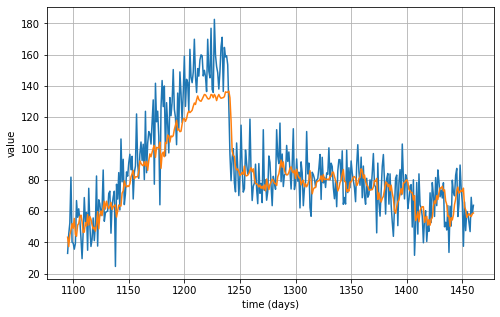

In [29]:
plt.figure(figsize=(8, 5))
plot_series(time_valid, x_valid)
plot_series(time_valid, c1d_lstm_forecast)

<div align="center">รูปที่ 5.12 ผลการพยากรณ์จากโมเดล Conv1D+LSTM</div>

ตรวจสอบค่าผิดพลาด

In [30]:
print(keras.metrics.mean_squared_error(x_valid, c1d_lstm_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, c1d_lstm_forecast).numpy())

303.06033
13.68358


## 5.5 การพัฒนางาน NLP โดย TF ขั้นพื้นฐาน

ในหัวข้อนี้จะกล่าวถึงพื้นฐาน <em>การประมวลผลภาษาธรรมชาติ (NLP : natural language processing)</em> 
และการพัฒนาโมเดลลำดับโดยใช้ TF 
โดยตัวอย่างจะใช้ประโยคภาษาอังกฤษที่ไม่ซับซ้อนเพื่อความเข้าใจในหลักการเบื้องต้น ซึ่งสามารถประยุกต์ใช้กับภาษาไทยโดยผ่านขั้นตอนวิธีการตัดคำ 

ปัญหาหลักของการประมวลผลข้อมูลในรูปประโยคคือแต่ละประโยคประกอบด้วยคำ มีการเรียบเรียงและความยาวแตกต่างกัน 
แต่โมเดลเชิงลึกที่เราศึกษามาแต่ต้นจะประมวลผลข้อมูลที่เป็นค่าตัวเลข ดังนั้นจึงต้องแปลงคำในภาษาให้เป็นตัวเลขเสียก่อน 
ซึ่งจำนวนคำในภาษาที่ใช้งานทั่วไปอาจมีจำนวนมากเกินกว่าค่าที่เรากำหนดให้กับโมเดล ในส่วนเริ่มต้นจะกล่าวถึงการดำเนินการเหล่านี้

### 5.5.1 การเข้ารหัสคำ

การเข้ารหัส (encoding) สามารถทำได้ในระดับต่ำสุดคืออักขระ (character) ในรูปโค้ดแอสกี (ASCII code) หรือสูงขึ้นคือระดับคำ 
ซึ่งในหัวข้อย่อยนี้จะกล่าวถึงวิธีการหลัง 

ยกตัวอย่างประโยคอย่างง่าย "I borrow money from my wife." ซึ่งอาจเปลี่ยนจาก "wife" เป็น "friend" การเข้ารหัสโดยใช้ API ของ TF 
ทำได้ดังนี้ เริ่มจากการนำเข้าไลบรารีที่ใช้งาน

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

นิยามประโยคที่ต้องการแปลง

In [32]:
sentences = [
    'I borrow money from my wife.',
    'I borrow money from my friend!'
]

เรียกใช้ <code>Tokenizer()</code> โดยกำหนดจำนวนคำ และสั่งให้แปลงประโยคในลิสต์

In [33]:
tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)

แสดงดัชนีของคำได้โดยคำสั่ง

In [34]:
word_index = tokenizer.word_index
print(word_index)

{'i': 1, 'borrow': 2, 'money': 3, 'from': 4, 'my': 5, 'wife': 6, 'friend': 7}


สังเกตว่าคำใน word_index จะถูกแปลงเป็นตัวเล็กหมด คำที่ซ้ำกันจะถูกกำหนดดัชนีเดียวกัน และเครื่องหมายเช่น . ! ถูกตัดทิ้งไป กล่าวคือ "friend" 
หรือ "friend!" จะถูกกำหนดดัชนีเดียวกัน

ทดลองเพิ่มประโยคในลิสต์เป็น

In [35]:
sentences = [
    'I borrow money from my wife.',
    'I borrow money from my friend!',
    'You borrow money from me',
    'Do you think I am a rich person?'
]

แปลงคำในประโยคเป็นดัชนีตัวเลขโดยใช้โค้ดเดิม หลังจากนั้นแปลงแต่ละประโยคเป็นลำดับของตัวเลข ได้เอาต์พุตดังนี้

In [36]:
tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
print(word_index)
print(sequences)

{'i': 1, 'borrow': 2, 'money': 3, 'from': 4, 'my': 5, 'you': 6, 'wife': 7, 'friend': 8, 'me': 9, 'do': 10, 'think': 11, 'am': 12, 'a': 13, 'rich': 14, 'person': 15}
[[1, 2, 3, 4, 5, 7], [1, 2, 3, 4, 5, 8], [6, 2, 3, 4, 9], [10, 6, 11, 1, 12, 13, 14, 15]]


โดย <code>word_index</code> คือดิกชันนารีที่กำหนดดัชนีให้กับคำ และ <code>sequence</code> เป็นลำดับของตัวเลขดัชนีในแต่ละประโยค 

ปัญหาแรกที่เกิดขึ้นเมื่อทดสอบกับประโยคที่มีบางคำไม่ได้บรรจุไว้ในคลังศํพท์ปัจจุบันของเรา ตัวอย่างเช่น

In [37]:
test_sentences = [
    'I also borrow money from my sister',
    'I am rich now.'
]
test_seq = tokenizer.texts_to_sequences(test_sentences)
print(test_seq)

[[1, 2, 3, 4, 5], [1, 12, 14]]


จะพบว่า <code>'also' , 'sister'</code> และ <code>'now'</code>
เป็นคำที่ไม่มีในดิกชันนารี <code>word_index</code> จึงไม่สามารถกำหนดค่าดัชนีได้ นอกเหนือจากการใส่คำที่ขาดใน 
<code>word_index</code> 
ทางแก้ในกรณีทั่วไปคือกำหนดดัชนีสำหรับคำที่ขาด เรียกว่า <code>'OOV = out of vocaborary'</code>

In [38]:
tokenizer = Tokenizer(num_words = 100, oov_token='<OOV>')
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
test_seq = tokenizer.texts_to_sequences(test_sentences)
print(word_index)
print(test_seq)

{'<OOV>': 1, 'i': 2, 'borrow': 3, 'money': 4, 'from': 5, 'my': 6, 'you': 7, 'wife': 8, 'friend': 9, 'me': 10, 'do': 11, 'think': 12, 'am': 13, 'a': 14, 'rich': 15, 'person': 16}
[[2, 1, 3, 4, 5, 6, 1], [2, 13, 15, 1]]


จะเห็นว่าในครั้งนี้ <code>'also','sister','now'</code> ถูกกำหนดค่าดัชนีเป็น 1 คือ <code>'\<OOV\>'</code>

### 5.5.2 การเสริมเต็ม

จากตัวอย่างที่ผ่านมาจะเห็นว่าโดยทั่วไปแต่ละประโยคจะมีความยาวแตกต่างกัน เปรียบได้กับขนาดภาพอินพุตที่แตกต่างกันในโมเดล CNN 
ที่จะต้องถูกปรับให้มีขนาดเท่ากันก่อนการฝึก การปรับขนาดของลำดับตัวเลขที่แทนแต่ละประโยคทำได้โดย 
<em>การเสริมเต็ม (padding)</em> ด้วย 0 
ให้มีขนาดตามต้องการ ทำได้โดยเรียกใช้ <code>pad_sequences</code> ของ TF ดังนี้

In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

ทดลองเสริมเต็มลำดับ <code>sequences</code>

In [40]:
padded = pad_sequences(sequences)
print(padded)

[[ 0  0  1  2  3  4  5  7]
 [ 0  0  1  2  3  4  5  8]
 [ 0  0  0  6  2  3  4  9]
 [10  6 11  1 12 13 14 15]]


จะเห็นได้ว่าประโยคที่ 1-3 ถูกเสริมเต็มด้านหน้าด้วย 0 ให้มีความยาวเท่ากับประโยคสุดท้ายที่ยาวที่สุด เราสามารถเลือกเสริมเต็มทางด้านท้ายได้โดยใส่อาร์กิวเมนต์ดังนี้

In [41]:
padded = pad_sequences(sequences, padding='post')
print(padded)

[[ 1  2  3  4  5  7  0  0]
 [ 1  2  3  4  5  8  0  0]
 [ 6  2  3  4  9  0  0  0]
 [10  6 11  1 12 13 14 15]]


หรืออาจจกำหนดความยาวที่ต้องการ และเลือกว่าจะตัดข้อมูลด้านหน้าหรือด้านท้ายออกก็ได้

In [42]:
padded = pad_sequences(sequences, padding='post',maxlen=7, truncating='post')
print(padded)

[[ 1  2  3  4  5  7  0]
 [ 1  2  3  4  5  8  0]
 [ 6  2  3  4  9  0  0]
 [10  6 11  1 12 13 14]]


### 5.5.3 การฝังตรึงคำศัพท์

ในการแทนคำศัพท์ทั้งหมดที่มีในคลังด้วยเลขดัชนี แนวคิดขั้นพื้นฐานคือใช้เวกเตอร์วันฮ็อต (one-hot) ตัวอย่างเช่นมีคำศัพท์ทั้งหมด 10000 คำ 
สมมุติว่า 'money' มีดัชนีเท่ากับ 6012 แทนได้โดยเวกเตอร์วันฮ็อตความยาว 10000 และมีเพียงสมาชิกตัวที่ 6012 มีค่าเป็น 1 ที่เหลือเป็น 0 ทั้งหมด 
เป็นที่มาของคำว่าวันฮ็อต ในการอิมพลิเมนต์โดยภาษาคอมพิวเตอร์หลักมักมีวิธีการจัดการกับข้อมูลในลักษณะนี้ที่มีเลขศูนย์เป็นส่วนใหญ่
โดยจัดเก็บเพียงขนาดและตำแหน่งที่มีค่าหนึ่งเท่านั้นเพื่อประหยัดเนื้อที่หน่วยความจำ

อย่างไรก็ตาม การใช้เวกเตอร์วันฮ็อตมีข้อด้อยสำคัญคือ ไม่เอื้ออำนวยต่อการหาความสัมพันธ์ของความหมายคำศัพท์ ตัวอย่างเช่นในการวิจารณ์สินค้าหรือบริการ 
คำว่า 'great', 'beautiful', 'perfect' มีความหมายเชิงบวกขณะที่ 
'poor', 'disappointed', 'bad' เป็นด้านลบ 
วิธีการหนึ่งที่นิยมใช้คือแทนค่าคำศัพท์ด้วยเวกเตอร์เช่น $u, v$ และคำนวณค่าโคไซน์ของมุม $\theta$ ระหว่างเวกเตอร์

$$
\cos \theta = \frac{u^Tv}{\lVert u \rVert \lVert v \rVert} \tag{5.21}
$$

โดยคำที่มีความหมายใกล้เคียงกันจะมีค่า $\cos \theta$ เข้าใกล้ 1 แต่เมื่อแทนค่า $u, v$ เป็นแบบวันฮ็อตจะไม่สามารถใช้วิธีนี้ได้ 
เนื่องจากคุณสมบัติของเวกเตอร์วันฮ็อตคือทุกตัวตั้งฉากกันทำให้ $\cos \theta = 0$ ทั้งหมด ดังนั้นการกำหนดค่าเวกเตอร์ให้กับคำศัพท์ในคลังจะใช้วิธีการที่เรียกว่า
<em>การฝังตรึงคำศํพท์ (word embeddings)</em> ซึ่ง TF มีเครื่องมือช่วยในการสร้างชั้นฝังตรึงให้กับโมเดล

ในการใช้งานต้องนำเข้าไลบรารีดังนี้

In [43]:
from tensorflow.keras.layers import Embedding

สมมุติว่าต้องการสร้างชั้นฝังตรึงสำหรับคำศัพท์ 1000 คำ ให้เอาต์พุตเป็นเวกเตอร์ขนาด 32 เรียกว่า 
<em>ปริภูมิการฝังตรึง (embedding space)</em>
และอาจกำหนดความยาวอินพุตเท่ากับ 64 คือจำนวนคำในประโยคหลังการเสริมเต็มและ/หรือตัดคำแล้ว 
การเลือกใส่อาร์กิวเมนต์นี้หรือไม่ขึ้นอยู่กับสถาปัตยกรรมของโครงข่ายที่ใช้

In [44]:
embedding_layer = Embedding(1000, 32, input_length=64)

จะลองสร้างตัวอย่างของเล่นเพื่อสาธิตการใช้งาน โดยสร้างอินพุตเป็นค่าสุ่มแทนเลขดัชนีของประโยคที่เป็นอินพุตจำนวน 16 ตัวอย่าง

In [45]:
import numpy as np
test_input = np.random.randint(1000, size=(16,64))
embedded_inputs = embedding_layer(test_input)

จะได้เอาต์พุตเป็นเทนเซอร์ขนาด (16,64,32) แทนจำนวนตัวอย่าง ความยาวประโยค และมิติของปริภูมิการฝังตรึงตามลำดับ

In [46]:
embedded_inputs.shape

TensorShape([16, 64, 32])

<div style=".noindent"><b>ตัวอย่าง 5.4</b></div>

เราจะสาธิตการใช้ TF ในงานด้าน NLP โดยใช้ชุดข้อมูลที่มีให้ในไลบรารีชื่อว่า <code>"imdb_reviews"</code> โดย "imdb"ย่อมาจาก "internet movie database" 
ในชุดข้อมูลนี้จะรวบรวมประโยคที่วิจารณ์ภาพยนต์บนอินเทอร์เน็ตจำนวน 50,000 ตัวอย่าง 
และมีเลเบลว่าเป็นด้านบวกหรือลบ ชุดข้อมูลนี้เป็นส่วนหนึ่งของแพ็กเกจ <code>tfds</code> ซึ่งมีติดตั้งไว้แล้วใน google colab 
แต่หากทดลองตัวอย่างนี้บนเครืองคอมพิวเตอร์ของตัวเองอาจต้องติดตั้งเพิ่มเติมโดยรันคำสั่งในเซลล์นี้ (-q คือ 'quiet' ไม่ต้องการแสดงเอาต์พุตจากการติดตั้ง)

In [47]:
 !pip install -q tensorflow-datasets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2 requires libclang>=9.0.1, which is not installed.
tensorflow 2.8.2 requires tensorflow-io-gcs-filesystem>=0.23.1, which is not installed.
tensorflow 2.8.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


นำเข้าไลบรารี TF และตรวจสอบเวอร์ชัน (ต้องเป็นเวอร์ชัน 2 ขึ้นไป)

In [48]:
import tensorflow as tf
tf.__version__

'2.8.2'

นำเข้า <code>tfds</code> และโหลด <code>"imdb_reviews"</code> โดยคำสั่งดังนี้

In [49]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/dew/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKHYBIW/imdb_reviews-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/dew/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKHYBIW/imdb_reviews-test.tfrec…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/dew/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKHYBIW/imdb_reviews-unsupervis…

Dataset imdb_reviews downloaded and prepared to /home/dew/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


ข้อมูลถูกแยกเป็นสำหรับฝึกและทดสอบอย่างละ 25,000 ตัวอย่าง ใช้คำสั่งเพื่อแยกข้อมูลฝึกกับทดสอบ

In [50]:
train_data, test_data = imdb['train'], imdb['test']

จัดการข้อมูลเพิ่มเติมเพื่อให้อยู่ในรูปของประโยคและเลเบล

In [51]:
import numpy as np

training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())
for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

การกำหนดเลเบลคือ 0 = วิจารณ์ด้านลบ, 1 = วิจารณ์ด้านบวก ขั้นต่อไปคือ <em>การทำโทเค็น (tokenize)</em> 
เพื่อสร้างคลังศัพท์จำนวน 10,000 คำ โดยกำหนดคำศัพท์ที่ไม่มีในคลังเป็น OOV
และเสริมเต็มประโยคโดยวิธีการที่ได้กล่าวถึงก่อนหน้านี้ เลือกความยาวประโยคสูงสุด 120 
โดยประโยคที่ยาวเกินจะถูกตัดออกทางด้านท้าย ส่วนประโยคที่สั้นกว่าจะถูกเสริมเต็มด้านหน้าด้วย 0 

In [52]:
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

การทดสอบเบื้องต้นจะสร้างโมเดลที่ประกอบด้วยชั้นฝังตรึงคำศัพท์ร่วมกับโครงข่ายประสาทเทียมเชิงลึกแบบธรรมดา 
โดยมีมิติฝังตรึงเท่ากับ 16 
คอมไพล์โดยใช้ฟังก์ชันสูญเสียแบบ <code>'binary_crossentropy'</code>
และใช้ตัวหาค่าเหมาะที่สุดแบบ <code>'adam'</code> ใช้ <code>model.summary()</code> 
เพื่อพิมพ์สรุปโครงสร้างของโมเดล

In [53]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
embedding_dim = 16
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Flatten(),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense_3 (Dense)             (None, 6)                 11526     
                                                                 
 dense_4 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


```
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense_3 (Dense)             (None, 6)                 11526     
                                                                 
 dense_4 (Dense)             (None, 1)                 7         
                                                                 
=================================================================
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________
```


ใช้ <code>model.fit()</code> เพื่อฝึกโมเดลโดยกำหนดจำนวน 10 รอบ 
พบว่าจะได้ความแม่นยำจากข้อมูลฝึกใกล้เดียง 100% แต่ความแม่นยำจากข้อมูลตรวจสอบประมาณ 
80% แสดงถึงการฟิตเกิน 

In [54]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 21s 26ms/step - loss: 0.5004 - accuracy: 0.7341 - val_loss: 0.3405 - val_accuracy: 0.8522
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2403 - accuracy: 0.9066 - val_loss: 0.3668 - val_accuracy: 0.8407
Epoch 3/10
782/782 [==============================] - 10s 13ms/step - loss: 0.0916 - accuracy: 0.9766 - val_loss: 0.4491 - val_accuracy: 0.8279
Epoch 4/10
782/782 [==============================] - 24s 30ms/step - loss: 0.0215 - accuracy: 0.9974 - val_loss: 0.5352 - val_accuracy: 0.8252
Epoch 5/10
782/782 [==============================] - 15s 20ms/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 0.5992 - val_accuracy: 0.8276
Epoch 6/10
782/782 [==============================] - 11s 14ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6504 - val_accuracy: 0.8290
Epoch 7/10
782/782 [==============================] - 20s 26ms/step - loss: 8.5206e-04 - accuracy: 1.0000 - val_loss: 0.6871 - val_accurac

```{admonition} ตัวอย่างเอาต์พุต
:class: tip
<div style="font-size: 12pt">
<br>Epoch 1/10
<br>782/782 [===...===] - 21s 26ms/step - loss: 0.5004 - accuracy: 0.7341 - val_loss: 0.3405 - val_accuracy: 0.8522
<br>Epoch 2/10
<br>782/782 [===...===] - 7s 9ms/step - loss: 0.2403 - accuracy: 0.9066 - val_loss: 0.3668 - val_accuracy: 0.8407

<br>:
<br>Epoch 10/10
<br>782/782 [===...===] - 10s 13ms/step - loss: 1.6083e-04 - accuracy: 1.0000 - val_loss: 0.8064 - val_accuracy: 0.8295
</div>
```

ในการที่จะพล็อตดูการจับกลุ่มของคำที่มีความหมายด้านบวกหรือลบ เราจะเขียนฟังก์ชันช่วยเพื่อผกผันคำศัพท์และดัชนี 

In [55]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

ดึงค่าน้ำหนักจากชั้นฝังตรึงคือชั้นที่ 0

In [56]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


เขียนข้อมูลคำศัพท์และดัชนีลงในไฟล์ที่จะถูกอ่านโดยเครื่องมือ tensorflow projector โดยไฟล์ชื่อ 'vecs.tsv' มีข้อมูลจากแอเรย์ของชั้นฝังตรึง 
คือค่าสัมประสิทธิ์ของแต่ละมิติในเวกเตอร์แต่ละคำนั่นเอง และ 'meta.tsv' คือตัวคำศัพท์ ทั้งสองไฟล์จะถูกสร้างที่ไดเรคทอรีเดียวกับที่รันสมุดบันทึกนี้ 

In [57]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

เปิดเบราเซอร์ชี้ไปที่ https://projector.tensorflow.org คลิปที่ปุ่ม [Load] ทางด้านซ้าย เลือกไฟล์ 'vecs.tsv', 'meta.tsv' 
สำหรับ vectors และ metadata ตามลำดับ จะเห็นการแทนแต่ละคำด้วยเวกเตอร์ที่แสดงเป็นจุดสีน้ำเงิน 
ตรวจสอบทิศทางของเวกเตอร์แทนคำที่มีความหมายใกล้เคียงกันดังแสดงในรูปที่ 5.13 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1SlyDF845m_qK2PQn0ZMF1hWtqRL74I3W" width=750 />
</p>
<div align="center">รูปที่ 5.13 การฉายเวกเตอร์ฝังตรึงที่แทนคำศัพท์</div>


หลังจากทดลองใช้โครงข่ายประสาทเทียมเชิงลึกธรรมดาเป็นโมเดลเส้นฐานแล้ว ต่อมาจะแสดงการสร้างโมเดลลำดับโดยใช้ชั้นฝังตรึงร่วมกับชั้น LSTM สองทาง 

In [58]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,Bidirectional,LSTM, Dense
model = Sequential([
    Embedding(vocab_size, 64, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 64)           640000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 120, 128)         66048     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 751,489
Trainable params: 751,489
Non-tr

```
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 embedding_2 (Embedding)     (None, 120, 64)           640000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 120, 128)         66048     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
=================================================================
Total params: 751,489
Trainable params: 751,489
Non-trainable params: 0
_________________________________________________________________
```

In [59]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
num_epochs = 10
history=model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 170s 212ms/step - loss: 0.4565 - accuracy: 0.7840 - val_loss: 0.3847 - val_accuracy: 0.8244
Epoch 2/10
782/782 [==============================] - 174s 222ms/step - loss: 0.3021 - accuracy: 0.8790 - val_loss: 0.3582 - val_accuracy: 0.8477
Epoch 3/10
782/782 [==============================] - 169s 216ms/step - loss: 0.2246 - accuracy: 0.9140 - val_loss: 0.4105 - val_accuracy: 0.8318
Epoch 4/10
782/782 [==============================] - 166s 213ms/step - loss: 0.1544 - accuracy: 0.9432 - val_loss: 0.5065 - val_accuracy: 0.8238
Epoch 5/10
782/782 [==============================] - 170s 218ms/step - loss: 0.0996 - accuracy: 0.9648 - val_loss: 0.5780 - val_accuracy: 0.8241
Epoch 6/10
782/782 [==============================] - 159s 204ms/step - loss: 0.0632 - accuracy: 0.9790 - val_loss: 0.7208 - val_accuracy: 0.8221
Epoch 7/10
782/782 [==============================] - 162s 207ms/step - loss: 0.0555 - accuracy: 0.9815 - val_loss: 0.6706 -

```{admonition} ตัวอย่างเอาต์พุต
:class: tip
<div style="font-size: 12pt">
<br>Epoch 1/10
<br>782/782 [===...===] - 170s 212ms/step - loss: 0.4565 - accuracy: 0.7840 - val_loss: 0.3847 - val_accuracy: 0.8244
<br>Epoch 2/10
<br>782/782 [===...===] - 174s 222ms/step - loss: 0.3021 - accuracy: 0.8790 - val_loss: 0.3582 - val_accuracy: 0.8477
<br>:
<br>Epoch 10/10
<br>782/782 [===...===] - 155s 198ms/step - loss: 0.0205 - accuracy: 0.9936 - val_loss: 0.8885 - val_accuracy: 0.8210
</div>
```

สังเกตว่าการฝึกจะใช้เวลานานขึ้นกว่าเดิม พล็อตความแม่นยำและค่าสูญเสียต่อรอบการฝึกได้ดังรูปที่ 5.14 และ 5.15 ตามลำดับ

In [61]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

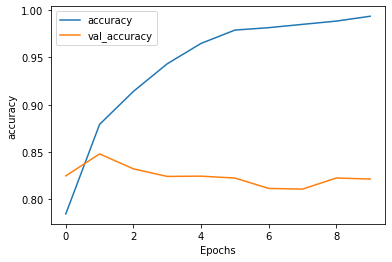

In [62]:
plot_graphs(history, 'accuracy')

รูปที่ 5.14 ความแม่นยำของโมเดลลำดับเทียบกับจำนวนรอบการฝึก

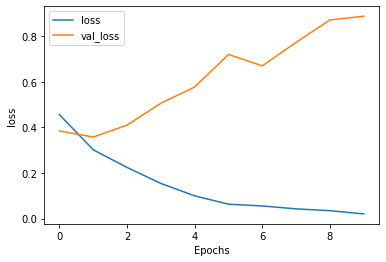

In [63]:
plot_graphs(history, 'loss')

รูปที่ 5.15 ค่าสูญเสียของโมเดลลำดับเทียบกับจำนวนรอบการฝึก

## 5.6 สรุปท้ายบท

เนื้อหาในบทนี้กล่าวถึงสถาปัตยกรรมโครงข่ายประสาทเทียมที่ใช้กับข้อมูลลำดับเริ่มจากโมเดลพื้นฐานคือ RNN จนถึงโมเดลขั้นสูงขึ้นคือ GRU, LSTM 
และยกตัวอย่างการสร้างโมเดลบนกรอบการทำงานของ TF 

ถึงแม้ว่า RNN, GRU, LSTM จะสามารถทำงานกับข้อมูลลำดับได้อย่างมีประสิทธิภาพ สถาปัตยกรรมนี้ยังมีข้อด้อยในประเด็นดังนี้

<ol>
<li />การหายไปของเกรเดียนต์สำหรับโมเดลที่มีขั้นลำดับยาวมากยังคงเป็นปัญหา
<li />โมเดลจำเป็นต้องประมวลผลตามลำดับขั้นเวลา จึงไม่สามารถใช้ประโยชน์จากตัวประมวลผลแบบขนานเช่น GPU
<li />การถ่ายโอนการเรียนรู้โดยทั่วไปไม่ประสบผลสำเร็จ โมเดลต้องการการฝึกโดยข้อมูลจำเพาะสำหรับปัญหานั้น
</ol>

โดยเหตุนี้เองปัจจุบันจึงมีการนำเสนอสถาปัตยกรรมทางเลือกสำหรับปัญหาเช่น NLP โดยใช้ทรานส์ฟอร์มเมอร์ส (transformers)
ซึ่งอาศัยกลไกของตัวเข้ารหัส ตัวถอดรหัส และความสนใจ (attention) ข้อแตกต่างหลักคือจะประมวลผลข้อมูลลำดับพร้อมกันทั้งชุด 
ดังนั้นสามารถใช้ประโยชน์จาก GPU ได้ อย่างไรก็ตามจะไม่สามารถใช้กับข้อมูลขั้นเวลาในรูปแบบเรียลไทม์ เช่นอินพุตที่รับโดยหุ่นยนต์ขณะทำงาน
ทรานส์ฟอร์มเมอร์สเป็นเนื้อหาที่อยู่นอกขอบเขตหนังสือนี้

## โจทย์ปัญหา

5-1 จากตัวอย่าง 5.1 - 5.3 ปรับแต่งโมเดลและ/หรือไฮเปอร์พารามิเตอร์เพื่อปรับปรุงค่าผิดพลาดให้น้อยลง โดยตั้งเป้าว่าควรน้อยกว่าค่าที่ได้จากโมเดล DNN 
ในภาคผนวก A 

5-2 ใช้โมเดลจากตัวอย่าง 5.1 - 5.3 พยากรณ์ข้อมูลจุดบอดบนดวงอาทิตย์ (sunspot) ดาวน์โหลดข้อมูลได้จากโค้ดด้านล่าง พล็อตข้อมูลได้ดังแสดงในรูปที่ P5.2

In [64]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-12-04 17:26:47--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.04s   

2022-12-04 17:26:47 (1.76 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



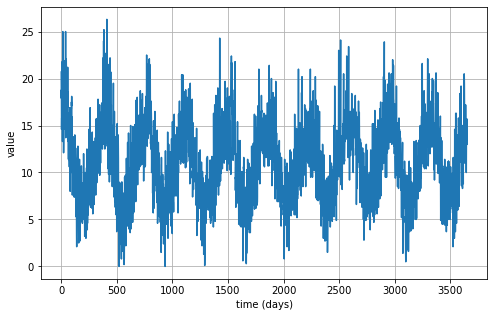

In [65]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(8,5))
plot_series(time, series)

<div align="center">รูปที่ P5.1 ข้อมูลจุดบอดบนดวงอาทิตย์</div>

5-3 พิจารณาโมเดลลำดับต่อไปนี้ว่าจัดอยู่ในประเภทใด (a-d) ในหัวข้อ 5.2.3 โดยมีอินพุตคือ $x$ และเอาต์พุตคือ $y$

1. การรู้จำเสียง (speech recognition) : $x$ คือไฟล์สัญญาณเสียง $y$ คือสตริงประโยคที่ถอดความจากเสียง

2. การกำเนิดดนตรี : $x$ คือเซตว่าง (ไม่มีอินพุต) $y$ คือโน้ตดนตรี
    
3. การวัดความพึงพอใจในบริการ : $x$ คือสตริงของประโยคจากลูกค้า $y$ คือจำนวนดาวที่ได้รับ
    
4. การแปลอังกฤษเป็นไทยโดยเครื่อง : $x$ คือประโยคภาษาอังกฤษ $y$ คือประโยคที่ถูกแปลเป็นภาษาไทย
    
5. การรู้จำกิจกรรมจากวีดิทัศน์ : $x$ คือคลิปวีดิทัศน์ $y$ คือการระบุกิจกรรมจากคลิป เช่น การแข่งขันฟุตบอล
    
6. การสั่งงานหลอดไฟโดยเสียง : $x$ คือไฟล์สัญญาณเสียง $y$ คือการปิด/เปิด/ปรับความสว่าง/เปลี่ยนสีหลอดไฟ

5-4 จากโมเดลลำดับพื้นฐานที่ได้ศึกษาในบทนี้ เราจะพบข้อจำกัดโดยเฉพาะในด้านการแปลภาษา เมื่อข้อความอินพุตมีความยาวมาก 
เมื่อเปรียบเทียบการทำงานกับมนุษย์ที่ทำงานเป็นล่ามแปลภาษา เราจะพบว่าโดยทั่วไปมนุษย์จะไม่จดจำประโยคอินพุตที่ยาวมากทั้งหมดแล้วแปลในครั้งเดียว
แต่จะตัดประโยคอินพุตเป็นช่วงแล้วแปลก่อนจะรับอินพุตต่อไป ซึ่งหลักการนี้ถูกใช้ในโมเดลที่ใช้หลักการของ "ความสนใจ" ที่เนื้อหาไม่ได้ถูกครอบคลุมในบทนี้ 
ผู้อ่านที่สนใจสามารถศึกษาเพิ่มเติมได้จาก {cite}`bahdanau2014neural`,{cite}`xu2015attend` อธิบายข้อได้เปรียบของการใช้ความสนใจเพื่อปรับปรุงสถาปัตยกรรมของโมเดลลำดับ 
